In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import dask
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [2]:
online_group = "zc-emu-1year-run-segmented-v3-online"
offline_group = "zc-emu-1year-run-segmented-v2-offline"

In [3]:
grid = vcm.catalog.catalog["grid/c48"].to_dask()

In [4]:
def _prepare_global_average(group, field):
    data = common.open_group(group)
    average_dims = list(set(data[field].dims) - set(["time", "z"]))
    field_data = data[field]
    if "online" in group:
        field_data = field_data.isel(time=slice(-1))

    return vcm.weighted_average(field_data, grid.area, dims=average_dims)

In [5]:
fields = ["air_temperature", "specific_humidity", "cloud_water_mixing_ratio", "total_precipitation"]

In [6]:
args = list(product([online_group, offline_group], fields))
jobs = [delayed(_prepare_global_average)(g, f) for g, f in args]
to_load = Parallel(n_jobs=8)(jobs)

In [7]:
arg_to_load_map = {a: v for a, v in zip(args, to_load)}

In [6]:
client = dask.distributed.Client()

In [9]:
@common.memoize_xarray_out
def get_global_average_early_test(group, field):
    return arg_to_load_map[(group, field)].load()

In [10]:
results = [get_global_average_early_test(*key) for key in arg_to_load_map]    

In [11]:
offline = xr.Dataset()
online = xr.Dataset()

for (group, _), res in zip(args, results):
    if "offline" in group:
        offline = offline.merge(res)
    else:
        online = online.merge(res)

In [12]:
diff = online - offline

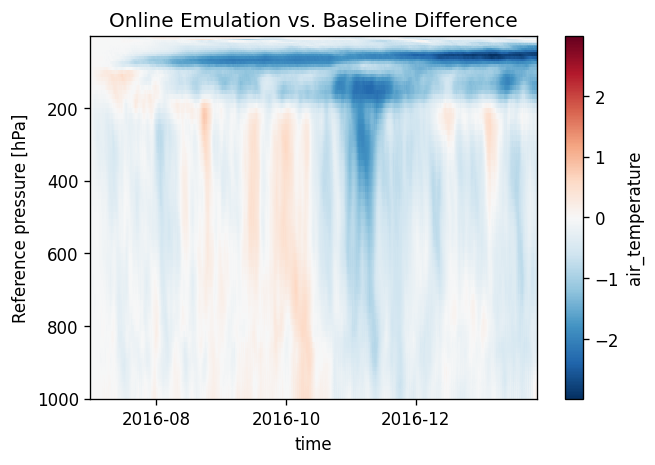

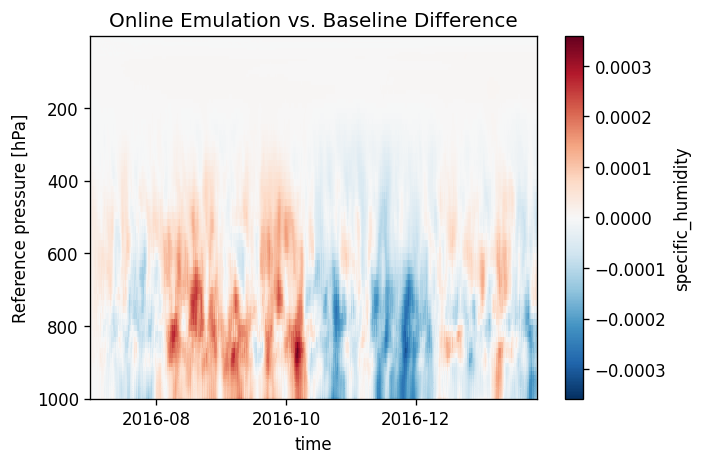

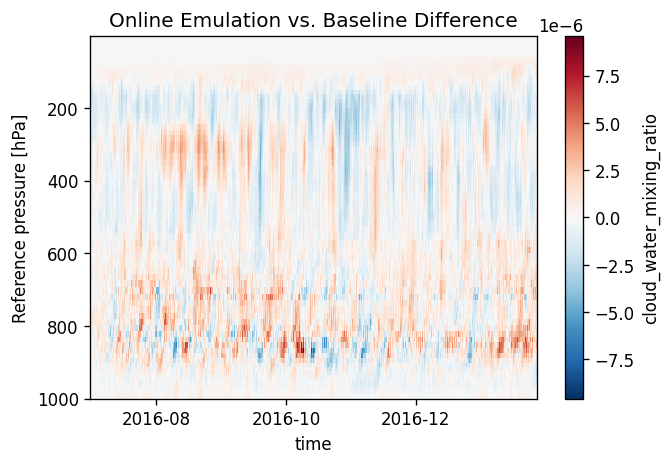

In [13]:
for f in fields:
    if "precip" in f:
        continue
    plt.figure(dpi=120)
    diff[f].plot(y="z", yincrease=False)
    plt.title("Online Emulation vs. Baseline Difference")
    plt.ylabel("Reference pressure [hPa]")
    plt.show()

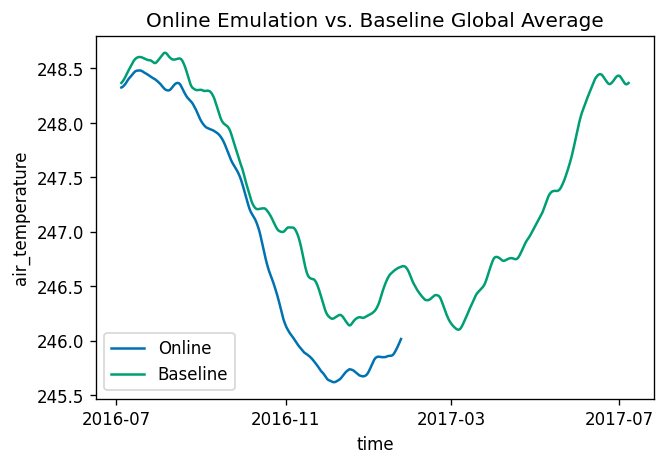

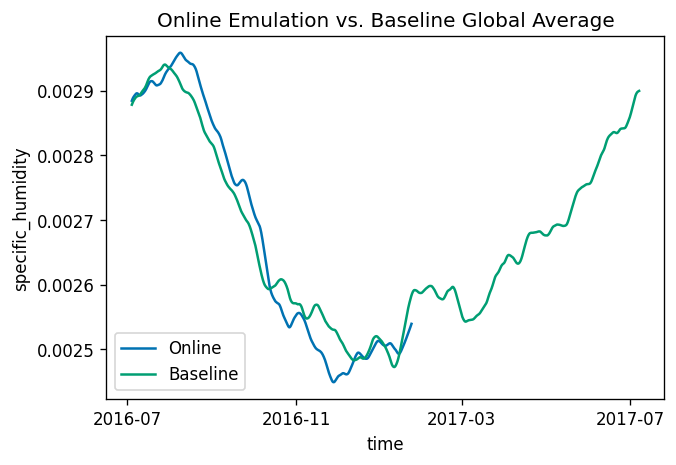

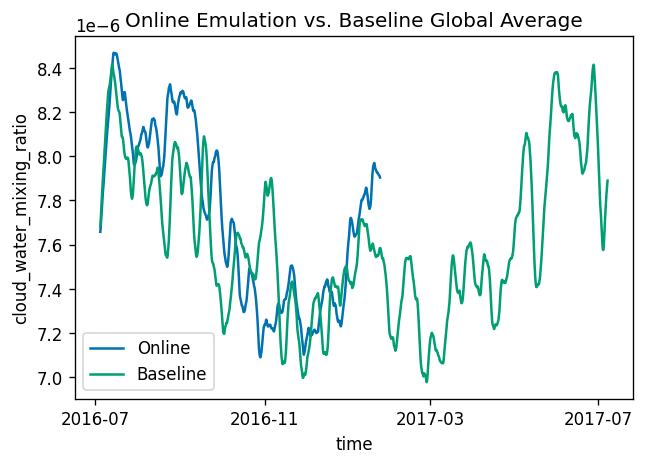

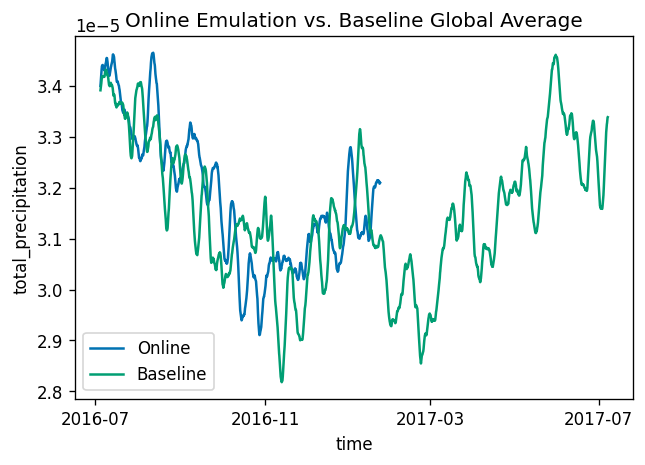

In [15]:
for f in fields:
    plt.figure(dpi=120)
    online.mean(dim="z")[f].rolling(time=7*8, center=True).mean().plot(label="Online")
    offline.mean(dim="z")[f].rolling(time=7*8, center=True).mean().plot(label="Baseline")
    plt.title("Online Emulation vs. Baseline Global Average")
    plt.legend()
    plt.show()

## Hovemoller Diagrams

In [7]:
# column integrated qc, precipitable water, and precip mm/day, radiation
from importlib import reload


<module 'common' from '/home/andrep/repos/fv3net/projects/microphysics/docs/manuscript/common.py'>

In [16]:

reload(common)

<module 'common' from '/home/andrep/repos/fv3net/projects/microphysics/docs/manuscript/common.py'>

In [11]:
tmp = common.open_group(online_group)

In [12]:
print(list(tmp.data_vars))

['air_temperature', 'cloud_water_mixing_ratio', 'eastward_wind', 'land_sea_mask', 'latitude', 'longitude', 'northward_wind', 'pressure_thickness_of_atmospheric_layer', 'specific_humidity', 'surface_pressure', 'total_precipitation', 'vertical_wind', 'delp', 'surface_precipitation_due_to_zhao_carr_emulator', 'surface_precipitation_due_to_zhao_carr_physics', 'tendency_of_air_temperature_due_to_gscond_emulator', 'tendency_of_air_temperature_due_to_gscond_physics', 'tendency_of_air_temperature_due_to_zhao_carr_emulator', 'tendency_of_air_temperature_due_to_zhao_carr_physics', 'tendency_of_cloud_water_due_to_gscond_emulator', 'tendency_of_cloud_water_due_to_gscond_physics', 'tendency_of_cloud_water_due_to_zhao_carr_emulator', 'tendency_of_cloud_water_due_to_zhao_carr_physics', 'tendency_of_specific_humidity_due_to_gscond_emulator', 'tendency_of_specific_humidity_due_to_gscond_physics', 'tendency_of_specific_humidity_due_to_zhao_carr_emulator', 'tendency_of_specific_humidity_due_to_zhao_carr_

In [15]:
tmp["cloud_water_mixing_ratio"]

<xarray.DataArray 'cloud_water_mixing_ratio' (time: 2760, tile: 6, z: 79, y: 48, x: 48)>
dask.array<truediv, shape=(2760, 6, 79, 48, 48), dtype=float64, chunksize=(1, 6, 79, 48, 48), chunktype=numpy.ndarray>
Coordinates:
  * tile     (tile) int64 0 1 2 3 4 5
  * z        (z) float64 4.514 8.301 12.45 16.74 ... 983.8 989.5 994.4 998.3
  * y        (y) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 44.0 45.0 46.0 47.0 48.0
  * x        (x) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 44.0 45.0 46.0 47.0 48.0
  * time     (time) object 2016-07-01 03:00:00 ... 2017-06-11 00:00:00
Attributes:
    units:      kg/kg
    long_name:  cloud_water_mixing_ratio

In [29]:
@common.memoize_xarray_out
def get_hovemoller_1yr_test(group):

    data = common.open_group(group)

    ds = xr.Dataset()

    ds["precip"] = vcm.zonal_average_approximate(
        grid.lat,
        common.m_to_mm_day(data["total_precipitation"])
    ).load()
    ds["cloud"] = vcm.zonal_average_approximate(
        grid.lat,
        common.kg_m2_to_mm(
            vcm.mass_integrate(
                data["cloud_water_mixing_ratio"],
                data["pressure_thickness_of_atmospheric_layer"],
                dim="z"
            )
        )
    ).load()
    ds["precipitable_water"] = vcm.zonal_average_approximate(grid.lat, data["PWAT"]).load()
    ds["longwave"] = vcm.zonal_average_approximate(grid.lat, data["ULWRFtoa"]).load()
    ds["shortwave"] = vcm.zonal_average_approximate(grid.lat, data["USWRFtoa"]).load()
    ds["height_500hpa"] = vcm.zonal_average_approximate(grid.lat, data["h500"]).load()

    return ds

In [30]:
online_zonal = get_hovemoller_1yr_test(online_group)

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
2023-01-26 22:55:33,063 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-01-26 22:55:56,805 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-26 22:56:23,003 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-26 22:57:29,086 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-01-26 22:57:57,794 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-01-26 22:58:32,358 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2

In [33]:
offline_zonal = get_hovemoller_1yr_test(offline_group)

2023-01-26 23:37:34,424 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-26 23:38:11,482 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-26 23:38:47,970 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-26 23:39:55,483 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-26 23:40:25,830 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-26 23:41:03,837 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-26 23:42:48,939 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-01-26 23:43:34,462 - distributed.utils_perf - WARNING - full garbage collections took

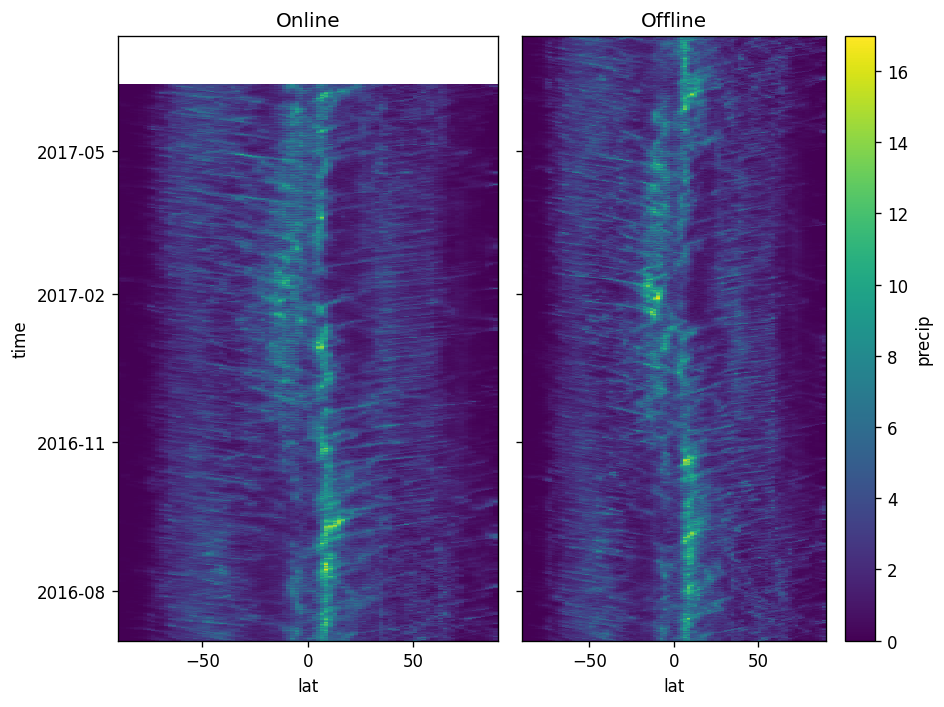

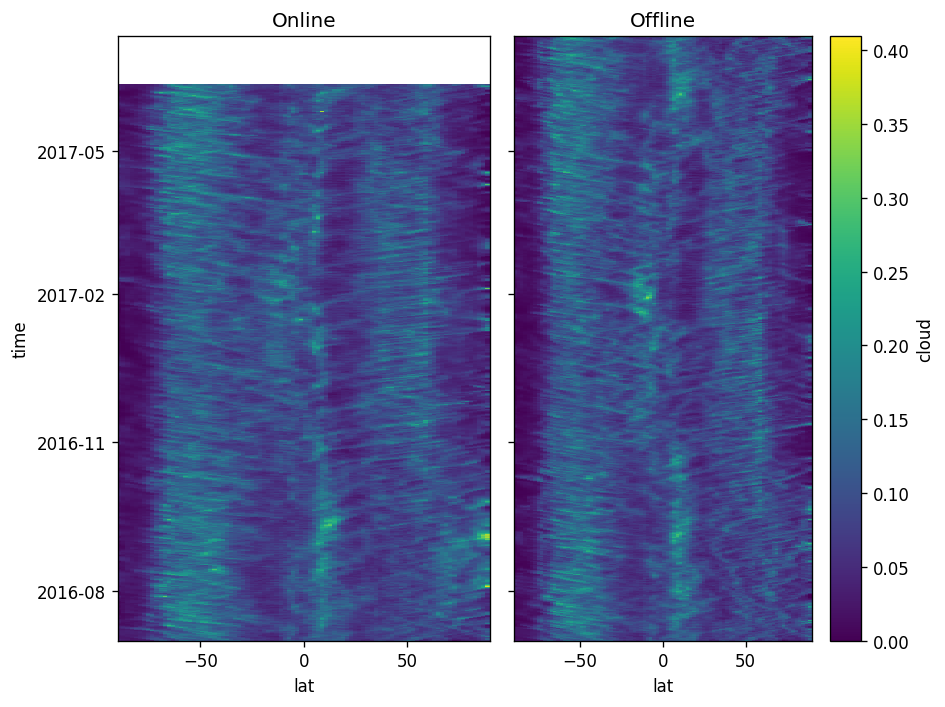

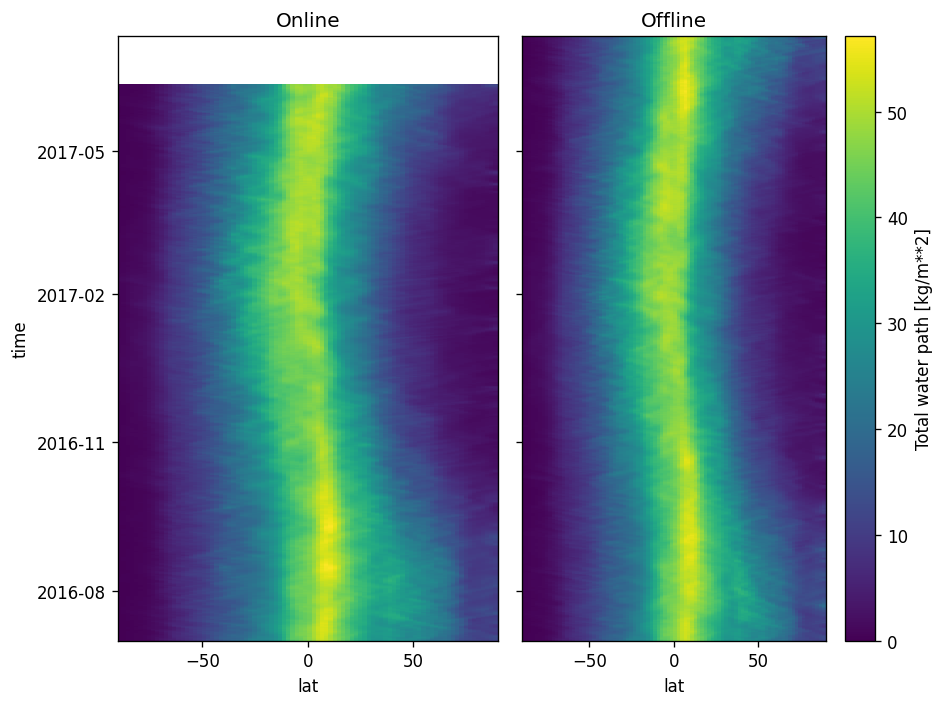

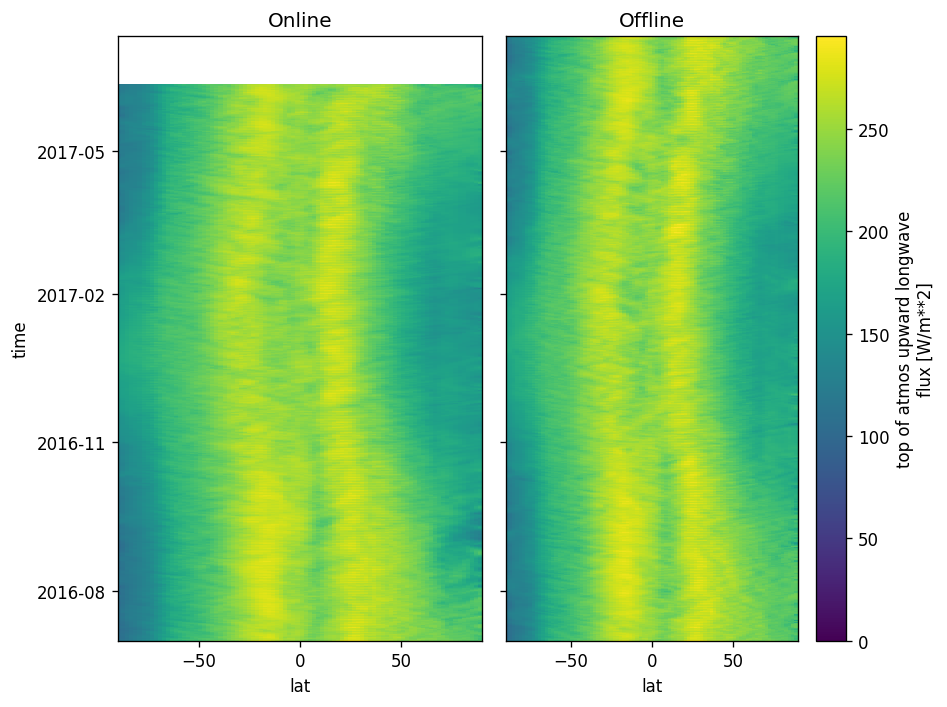

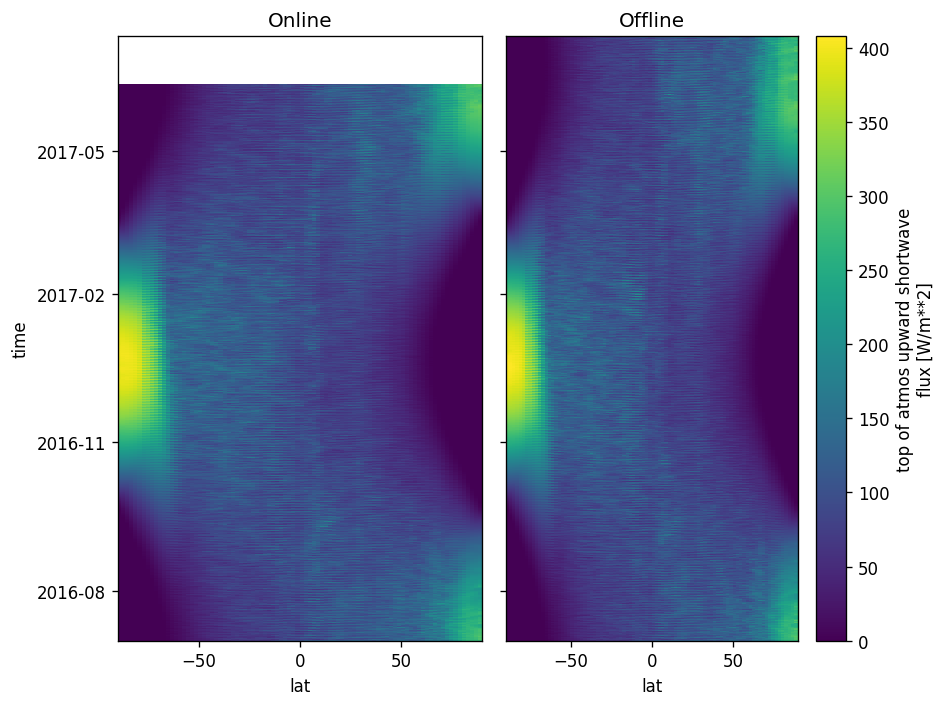

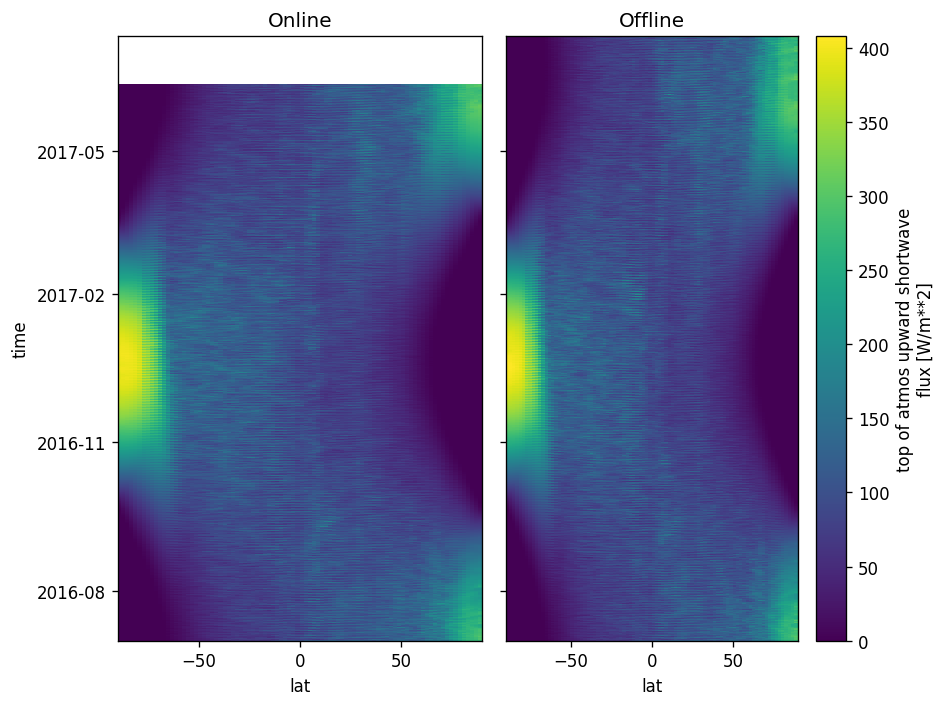

In [45]:
for k, v in online_zonal.items():
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8,6), dpi=120)
    vmin = 0
    vmax = max(v.max(), offline_zonal[k].max())
    v.plot(y="time", ax=ax[0], vmin=vmin, vmax=vmax, add_colorbar=False)
    offline_zonal[k].plot(y="time", ax=ax[1], vmin=vmin, vmax=vmax)
    ax[1].set_ylabel("")
    ax[0].set_title("Online")
    ax[1].set_title("Offline")
    plt.tight_layout()
    plt.show()